Love this idea. Yes—an LLM can absolutely extract the *essence* (vibe/feelings) from a user’s request and from candidate films, then you can match them. Here’s a tight plan you can implement without too much churn:

---

# What to extract (two complementary views)

1. **Discrete emotions (distribution)**

   * Labels (pick a small, stable set): e.g. `["uplifting","wholesome","melancholic","tense","dark","romantic","wistful","heartwarming","gritty","satirical"]`
   * Each with a score in `[0,1]` that sums to ≤ 1 (sparse) or normalize to sum=1.
   * Great for bar charts and keyword filtering.

2. **VAD coordinates**

   * **Valence** (sad ↔ happy), **Arousal** (calm ↔ intense), **Dominance** (helpless ↔ empowered), each in `[0,1]`.
   * Perfect for quick numeric matching (cosine/Euclidean) and a 2D/3D scatter.

You can keep both; they complement each other.

---

# Data flow (end-to-end)

1. **User essence extraction**

   * Input: the user’s free-text request (not genres).
   * LLM returns:

     ```json
     {
       "essence": {
         "emotions": [{"label":"heartwarming","score":0.42},{"label":"romantic","score":0.31},{"label":"wistful","score":0.19}],
         "vad": {"valence":0.76,"arousal":0.35,"dominance":0.54},
         "rationale": "Seeks cozy, gentle romance with a reflective tone."
       }
     }
     ```
   * Keep `temperature` low (0.1–0.3) for stable scoring.

2. **Filter candidates by hard constraints**

   * Use your existing genre/year/runtime filters to narrow the pool.

3. **Movie essence extraction**

   * For each candidate, pass **only** synopsis/keywords (optionally top review snippet) to the LLM and ask for the same schema:

     ```json
     {"emotions":[...], "vad": {...}, "rationale": "...", "evidence_spans": ["...quoted snippets..."]}
     ```
   * Cache these results by movie ID so you don’t rescore on every query.

4. **Similarity scoring**

   * **Emotions**: convert to vectors over your fixed label set; use **cosine similarity** (or Jensen–Shannon if normalized distributions).
   * **VAD**: cosine or Euclidean distance (invert to similarity).
   * Final score = `0.6 * emotion_sim + 0.4 * vad_sim` (tune weights).
   * Tie-break with popularity/rating or user constraints.

5. **UI**

   * Show **bar chart** of emotion scores (user vs. movie).
   * Show **VAD point** on a 2D Valence–Arousal plane (user vs. movie).
   * Display short `rationale` + `evidence_spans` for transparency.

---

# Prompt snippets (few-shot + JSON schema)

## System (shared for user/movie extraction)

```
You extract the affective "essence" of movie preferences and synopses.

Output strictly as JSON:
{
  "essence": {
    "emotions": [{"label":"<one of: uplifting, wholesome, melancholic, tense, dark, romantic, wistful, heartwarming, gritty, satirical>", "score": 0.0-1.0}, ...],
    "vad": {"valence":0.0-1.0,"arousal":0.0-1.0,"dominance":0.0-1.0},
    "rationale":"short 1-2 sentences",
    "evidence_spans": ["optional short quotes from input text"]
  }
}
Rules:
- Use only labels from the list.
- 1–5 emotions max; keep scores calibrated and sparse.
- VAD must reflect the overall feel, not plot intensity alone.
- Be concise; do not include extra keys.
```

## Few-shot (user request → essence)

**User:**

```
Something light and cozy about friendship, low stakes, gentle humor.
```

**Assistant:**

```json
{
  "essence": {
    "emotions": [
      {"label":"wholesome","score":0.42},
      {"label":"heartwarming","score":0.36},
      {"label":"satirical","score":0.08}
    ],
    "vad": {"valence":0.78,"arousal":0.28,"dominance":0.52},
    "rationale":"Wants cozy, low-stakes warmth and gentle humor.",
    "evidence_spans": ["light and cozy","gentle humor"]
  }
}
```

**User:**

```
I’m in the mood for a bleak, slow-burn mystery that feels suffocating.
```

**Assistant:**

```json
{
  "essence": {
    "emotions": [
      {"label":"tense","score":0.44},
      {"label":"dark","score":0.34},
      {"label":"melancholic","score":0.14}
    ],
    "vad": {"valence":0.18,"arousal":0.55,"dominance":0.32},
    "rationale":"Bleak tone and suffocating atmosphere imply low valence, mid arousal.",
    "evidence_spans": ["bleak","slow-burn","suffocating"]
  }
}
```

## Few-shot (movie synopsis → essence)

**User:**

```
SYNOPSIS: A widower restores a seaside inn, forming unlikely bonds while healing from loss; gentle humor, small-town rituals, and slow-blooming romance.
```

**Assistant:**

```json
{
  "essence": {
    "emotions": [
      {"label":"wistful","score":0.34},
      {"label":"heartwarming","score":0.32},
      {"label":"romantic","score":0.22}
    ],
    "vad": {"valence":0.62,"arousal":0.30,"dominance":0.48},
    "rationale":"Heals from loss with gentle humor and tender romance; reflective tone.",
    "evidence_spans": ["healing from loss","gentle humor","slow-blooming romance"]
  }
}
```

---

# Matching math (simple + effective)

* Let `E_user` and `E_movie` be vectors over your 10 labels (missing labels = 0).
* **Emotion similarity:** `cos_sim(E_user, E_movie)`.
* **VAD similarity:** `1 - euclidean(v_user, v_movie)` or cosine over 3D vectors.
* Final score: `S = 0.6*cos_emotions + 0.4*cos_vad`.
* Rank movies by `S`. Show the top N with rationales.

---

# Practicalities & guardrails

* **Calibration:** Keep temperature low; optionally rescale emotion scores to sum ≤ 1, and cap to 3–4 nonzero labels.
* **Caching:** Cache movie essence by `movie_id` + `synopsis_hash`.
* **Evidence:** Always request short quotes; it keeps the model honest.
* **Determinism:** Fix label set; don’t let the model invent labels.
* **Cheaper alt:** For movies, you can use an emotion classifier (e.g., GoEmotions) + a small mapping to your 10 labels, then only use the LLM for the user essence and for final justification.

---

# Streamlit integration ideas (quick wins)

* Show **radar chart** (emotion scores) and **2D V–A scatter** (user dot vs. movie dots).
* Add a **“Why this match?”** expander with the rationale + evidence spans.
* Use `st.spinner("Scoring matches…")` while you compute similarities.
* Cache movie essence with `@st.cache_data(show_spinner=False)`.

---

If you want, I can tailor the exact JSON schema + a tiny scoring function to what you’ve already built so you can drop it in with minimal rewiring.


100% yes—Pydantic is perfect for **validating and shaping** the “essence” data coming back from the LLM (and for your own internal plumbing).

Here’s a tight, practical setup you can drop in (Pydantic v2 style):

```python
from enum import Enum
from typing import List, Optional
from pydantic import BaseModel, Field, confloat, conlist, field_validator, model_validator

# 1) Fixed label set (prevents the LLM inventing labels)
class EmotionLabel(str, Enum):
    uplifting = "uplifting"
    wholesome = "wholesome"
    melancholic = "melancholic"
    tense = "tense"
    dark = "dark"
    romantic = "romantic"
    wistful = "wistful"
    heartwarming = "heartwarming"
    gritty = "gritty"
    satirical = "satirical"

# 2) Score + bounds
class EmotionScore(BaseModel):
    label: EmotionLabel
    score: confloat(ge=0.0, le=1.0)

# 3) VAD with bounds
class VAD(BaseModel):
    valence: confloat(ge=0.0, le=1.0)
    arousal: confloat(ge=0.0, le=1.0)
    dominance: confloat(ge=0.0, le=1.0)

# 4) Full essence payload
class Essence(BaseModel):
    emotions: conlist(EmotionScore, min_length=0, max_length=5) = Field(default_factory=list)
    vad: VAD
    rationale: Optional[str] = None
    evidence_spans: List[str] = Field(default_factory=list)

    model_config = {"extra": "forbid"}  # reject unexpected keys

    # Optional: clamp weird LLM outputs and dedupe labels
    @field_validator("emotions")
    @classmethod
    def dedupe_and_clip(cls, items: List[EmotionScore]):
        if not items:
            return items
        # keep highest score per label, preserve order
        seen = {}
        ordered = []
        for item in items:
            if item.label not in seen or item.score > seen[item.label].score:
                seen[item.label] = item
        for label in [i.label for i in items]:
            if label in seen:
                ordered.append(seen.pop(label))
        return ordered[:5]  # enforce sparsity

class EssenceResponse(BaseModel):
    essence: Essence
    model_config = {"extra": "forbid"}
```

### Why this helps

* **Guards the contract:** only allowed labels; scores in `[0,1]`; ≤5 emotions.
* **Prevents surprises:** `extra="forbid"` stops stray keys the LLM might add.
* **Cleans data:** validator dedupes labels and enforces sparsity.

### Parsing the LLM output

If you’re using OpenAI’s structured output helper:

```python
result = client.beta.chat.completions.parse(
    model=model,
    messages=messages,
    response_format=EssenceResponse,   # << pydantic model
)
ess = result.choices[0].message.parsed.essence
```

If you’re getting raw JSON text:

```python
ess = EssenceResponse.model_validate_json(raw_llm_text).essence
```

### Handy: vectorizing for similarity

```python
LABELS = [e.value for e in EmotionLabel]
index = {name: i for i, name in enumerate(LABELS)}

def to_vector(emotions: List[EmotionScore]) -> list[float]:
    v = [0.0] * len(LABELS)
    for es in emotions:
        v[index[es.label.value]] = float(es.score)
    return v
```

### Extra niceties (optional)

* **Coercion** (if LLM sometimes sends `"0.7"` or `"70%"`): add a `field_validator("score", mode="before")` in `EmotionScore` to parse strings/percentages.
* **Normalization** (if you want scores to sum to 1): add a `model_validator(mode="after")` in `Essence` to rescale.

This gives you strict, validated inputs for your matching logic and super clear error messages if the LLM goes off-script.


Absolutely—you can go **VAD-only** and keep it simple. It works well by itself for “vibe matching,” and it’s easy to compute, store, and visualize.

# Why VAD-only works

* One compact vector per thing (user or movie): `(valence, arousal, dominance)` in `[0,1]`.
* Simple scoring (cosine or Euclidean distance).
* Easy UI: plot Valence–Arousal, show Dominance as a slider or number.
* Faster/cheaper: fewer tokens than lists of emotion labels.

# Minimal schema (Pydantic)

```python
from pydantic import BaseModel, Field, confloat

class VAD(BaseModel):
    valence: confloat(ge=0.0, le=1.0) = Field(...)
    arousal: confloat(ge=0.0, le=1.0) = Field(...)
    dominance: confloat(ge=0.0, le=1.0) = Field(...)
```

# Prompt (few-shot)

Use the same prompt for user text and for movie synopsis.

```
You estimate Valence–Arousal–Dominance (VAD) for text.

Output JSON only:
{"vad":{"valence":0.0-1.0,"arousal":0.0-1.0,"dominance":0.0-1.0},"rationale":"<short>"}

Guidelines:
- Valence: unpleasant/sad=0.0 → pleasant/joyful=1.0
- Arousal: calm/slow=0.0 → intense/exciting=1.0
- Dominance: powerless/hemmed-in=0.0 → in-control/empowered=1.0
- Be concise. No extra keys.

Examples:
Text: "Cozy, low-stakes story about friends helping each other."
Output: {"vad":{"valence":0.8,"arousal":0.3,"dominance":0.5},"rationale":"Warm, calm support."}

Text: "Bleak slow-burn mystery that feels suffocating."
Output: {"vad":{"valence":0.2,"arousal":0.55,"dominance":0.3},"rationale":"Bleak tone, pressure."}
```

# Matching function

```python
import numpy as np

def vad_vector(v): return np.array([v.valence, v.arousal, v.dominance], dtype=float)

def vad_similarity(v_user, v_item, method="cosine"):
    u, i = vad_vector(v_user), vad_vector(v_item)
    if method == "cosine":
        return float(np.dot(u,i) / (np.linalg.norm(u)*np.linalg.norm(i) + 1e-9))
    # or Euclidean turned into similarity
    dist = float(np.linalg.norm(u - i))
    return 1.0 / (1.0 + dist)
```

# Workflow

1. **User input → LLM → VAD** (cache on the session).
2. **Candidate movies**: compute VAD once per movie from synopsis (cache by `movie_id`).
3. **Rank** by `vad_similarity(user_vad, movie_vad)`.
4. **UI**:

   * Show a Valence–Arousal scatter (user dot vs. top N movie dots).
   * Show Dominance values in a small table.
   * Include the LLM’s brief `rationale` for transparency.

# Practical tips

* **Temperature** low (0.1–0.3) for stable numbers.
* **Validation**: clamp to `[0,1]`; if model returns `0–100`, divide by 100.
* **Determinism**: fix the prompt and avoid adding genre/title—give just the user description or the movie synopsis.
* **Fallbacks**: if VAD missing, default to `(0.5, 0.5, 0.5)` and mark as low confidence.
* **Speed**: precompute movie VAD offline or on first view; cache with `@st.cache_data`.

# (Optional) Friendly labels for UI only

If you miss emotion words, you can **derive** a label from V–A quadrants:

* High V, Low A → “cozy/soothing”
* High V, High A → “rousing”
* Low V, High A → “tense”
* Low V, Low A → “somber”
  This is display-only; keep matching math purely VAD.

So yes—VAD-only is a great MVP. You can always add discrete emotion labels later if you want more explainability.


Awesome—here’s a line-by-line walkthrough of the NumPy scorer, tied to the math it implements, plus one small fix to make the distance scaling perfectly correct.

---

## `_vec(...)`: normalize any VAD into a centered 3-vector

```python
def _vec(vad: dict | tuple | list) -> np.ndarray:
    # expects {'valence': x, 'arousal': y, 'dominance': z} or [x,y,z]
    if isinstance(vad, dict):
        x = [vad["valence"], vad["arousal"], vad["dominance"]]
    else:
        x = vad
```

* Accept either a dict or sequence and pull out **(v, a, d)**.

```python
    a = np.asarray(x, dtype=float)
```

* Convert to a NumPy vector `a = [v, a, d]` with floats in **\[0,1]** (assumed).

```python
    # clamp to [0,1] just in case, center to [-1,1]
    a = np.clip(a, 0.0, 1.0) * 2.0 - 1.0
    return a
```

* Clamp to $[0,1]$ for safety, then **center** to $[-1,1]$ via

  $$
  a' = 2a - 1
  $$

  This makes **0.5 → 0 (neutral)**, **1 → +1**, **0 → −1**.

---

## `vad_similarity(...)`: weighted cosine + weighted distance blend

```python
def vad_similarity(user_vad, movie_vad, w=(1.0, 1.0, 0.7), alpha=0.6) -> float:
    u = _vec(user_vad)
    m = _vec(movie_vad)
    w = np.asarray(w, dtype=float)
```

* `u`, `m` are the centered VAD vectors in $[-1,1]^3$.
* `w = (w_v, w_a, w_d)` are **per-axis weights** (here, dominance is a bit lighter at 0.7).

```python
    u_w = u * w
    m_w = m * w
```

* Apply weights component-wise:

  $$
  \tilde{u} = w \odot u,\quad \tilde{m} = w \odot m
  $$

  (Hadamard product).

### Cosine similarity (directional “vibe”)

```python
    nu = np.linalg.norm(u_w)
    nm = np.linalg.norm(m_w)
    cos = float((u_w @ m_w) / (nu * nm)) if nu > 0 and nm > 0 else 0.0
```

* $\cos = \dfrac{\tilde{u} \cdot \tilde{m}}{\lVert \tilde{u}\rVert\,\lVert \tilde{m}\rVert}$
* If either vector is zero-norm, fall back to 0 (neutral).

### Euclidean distance → a \[0,1] “closeness” score

```python
    d = float(np.linalg.norm(u_w - m_w))
```

* Weighted Euclidean distance:

  $$
  d = \lVert \tilde{u} - \tilde{m}\rVert_2
  $$

```python
    dmax = 2.0 * float(np.sqrt(np.sum(w)))  # max possible in weighted [-1,1]^3
```

* **Small correction:** the true maximum distance after weighting is

  $$
  d_{\max} = 2\,\sqrt{\sum_i w_i^2}
  $$

  because the worst case is axis-aligned opposite corners (difference of 2 per axis), and weights enter **squared** inside the norm.
  So this line should be:

  ```python
  dmax = 2.0 * float(np.sqrt(np.sum(w**2)))
  ```

  (Using `np.sum(w)` slightly under/over scales depending on weights; the fix makes the distance score strictly within \[0,1].)

```python
    dist_score = 1.0 - (d / dmax)
```

* Convert distance to similarity in $[0,1]$:

  $$
  \text{dist\_score} = 1 - \frac{d}{d_{\max}}
  $$

  so 1 = identical, 0 = maximally far apart.

### Blend cosine + distance

```python
    return alpha * cos + (1 - alpha) * dist_score
```

* Final score:

  $$
  \text{score} = \alpha\,\cos + (1-\alpha)\,\text{dist\_score}
  $$

  with $\alpha=0.6$ giving slightly more weight to “directional vibe”.

---

## `rank_movies_by_vad(...)`: score and sort

```python
def rank_movies_by_vad(user_vad, movies_vad_array, movie_ids, **kwargs):
    # movies_vad_array: shape (N,3) in [0,1], same order as movie_ids
    scores = []
    for mv, mid in zip(movies_vad_array, movie_ids):
        s = vad_similarity(user_vad, mv, **kwargs)
        scores.append((mid, s))
    # sort high → low
    return sorted(scores, key=lambda t: t[1], reverse=True)
```

* Loop through each movie VAD, compute `vad_similarity`, collect `(id, score)`, and return them **sorted descending**.
* `movies_vad_array` should hold raw **\[0,1]** triples; the centering happens inside `vad_similarity`.

---

## Drop-in with the small fix

```python
import numpy as np

def _vec(vad):
    if isinstance(vad, dict):
        x = [vad["valence"], vad["arousal"], vad["dominance"]]
    else:
        x = vad
    a = np.asarray(x, dtype=float)
    a = np.clip(a, 0.0, 1.0) * 2.0 - 1.0  # center to [-1,1]
    return a

def vad_similarity(user_vad, movie_vad, w=(1.0, 1.0, 0.7), alpha=0.6) -> float:
    u = _vec(user_vad); m = _vec(movie_vad)
    w = np.asarray(w, dtype=float)

    u_w = u * w; m_w = m * w

    nu = np.linalg.norm(u_w); nm = np.linalg.norm(m_w)
    cos = float((u_w @ m_w) / (nu * nm)) if nu > 0 and nm > 0 else 0.0

    d = float(np.linalg.norm(u_w - m_w))
    dmax = 2.0 * float(np.sqrt(np.sum(w**2)))  # ← corrected
    dist_score = 1.0 - (d / dmax)

    return alpha * cos + (1 - alpha) * dist_score

def rank_movies_by_vad(user_vad, movies_vad_array, movie_ids, **kwargs):
    return sorted(
        ((mid, vad_similarity(user_vad, mv, **kwargs)) for mv, mid in zip(movies_vad_array, movie_ids)),
        key=lambda t: t[1],
        reverse=True,
    )
```

---

### Practical tips

* Clamp and round your VAD inputs to avoid tiny out-of-range noise.
* If a user/movie vector is exactly neutral $[0,0,0]$ after centering, cosine is undefined; the guard already returns 0.
* You can tune `w` and `alpha` based on feedback (e.g., if “energy” matters most, raise the arousal weight or `alpha`).


Here’s what that line does—in plain English:

```python
a = np.clip(a, 0.0, 1.0) * 2.0 - 1.0
```

1. **`np.clip(a, 0.0, 1.0)` (“clamp to \[0,1]”):**
   *Clamp* means “force values into a range.”

   * Any number below **0.0** becomes **0.0**.
   * Any number above **1.0** becomes **1.0**.
   * Values already between 0 and 1 stay the same.
     This is just a safety net in case something like 1.02 or -0.1 sneaks in.

2. **`* 2.0 - 1.0` (“center to \[-1,1]”):**
   After clamping, we linearly remap the 0–1 scale to -1–1:

   $$
   x' = 2x - 1
   $$

   So:

   * 0.0 → -1.0
   * 0.25 → -0.5
   * 0.5 → 0.0 (neutral)
   * 0.75 → 0.5
   * 1.0 → 1.0

**Why do this?**

* The VAD inputs are expected in **\[0,1]**. Clamping keeps them valid.
* Mapping to **\[-1,1]** makes the midpoint (**0.5**) land at **0**, which is convenient for similarity math (neutral vibe = 0).


Here’s that block in plain English:

```python
def vad_similarity(user_vad, movie_vad, w=(1.0, 1.0, 0.7), alpha=0.6) -> float:
    u = _vec(user_vad)
    m = _vec(movie_vad)
    w = np.asarray(w, dtype=float)
```

* `def vad_similarity(...):`
  We’re defining a function that returns **one number**: how well a movie’s vibe matches the user’s vibe.

  * `w` are **weights** for the three axes (Valence, Arousal, Dominance). Here we’re saying Valence=1.0, Arousal=1.0, Dominance=0.7 (a bit less important).
  * `alpha` is the **blend knob** used later to mix two similarity measures.

* `u = _vec(user_vad)`
  Take the user’s VAD (dict or list) and **standardize it** into a NumPy vector of three numbers in **\[-1, 1]**. (The helper `_vec` clamps to \[0,1] and recenters to \[-1,1].)

* `m = _vec(movie_vad)`
  Do the same for the movie’s VAD.

* `w = np.asarray(w, dtype=float)`
  Turn the weights into a NumPy array so we can do **fast, element-wise math** like multiplying each VAD axis by its weight.


Here’s the idea behind that expression, with a picture to make it concrete.

**Formula you asked about**

```python
cos = float((u_w @ m_w) / (nu * nm)) if nu > 0 and nm > 0 else 0.0
```

* `u_w @ m_w` = **dot product** of the two (weighted) vectors.
* `nu = ||u_w||`, `nm = ||m_w||` = their **lengths** (Euclidean norms).
* `cos = (u_w · m_w) / (||u_w|| * ||m_w||)` is the **cosine of the angle θ** between them.

  * `cos ≈ 1` → vectors point in the **same direction** (very similar vibe)
  * `cos ≈ 0` → vectors are roughly **orthogonal** (unrelated vibe)
  * `cos ≈ -1` → vectors point in **opposite directions** (opposite vibe)

  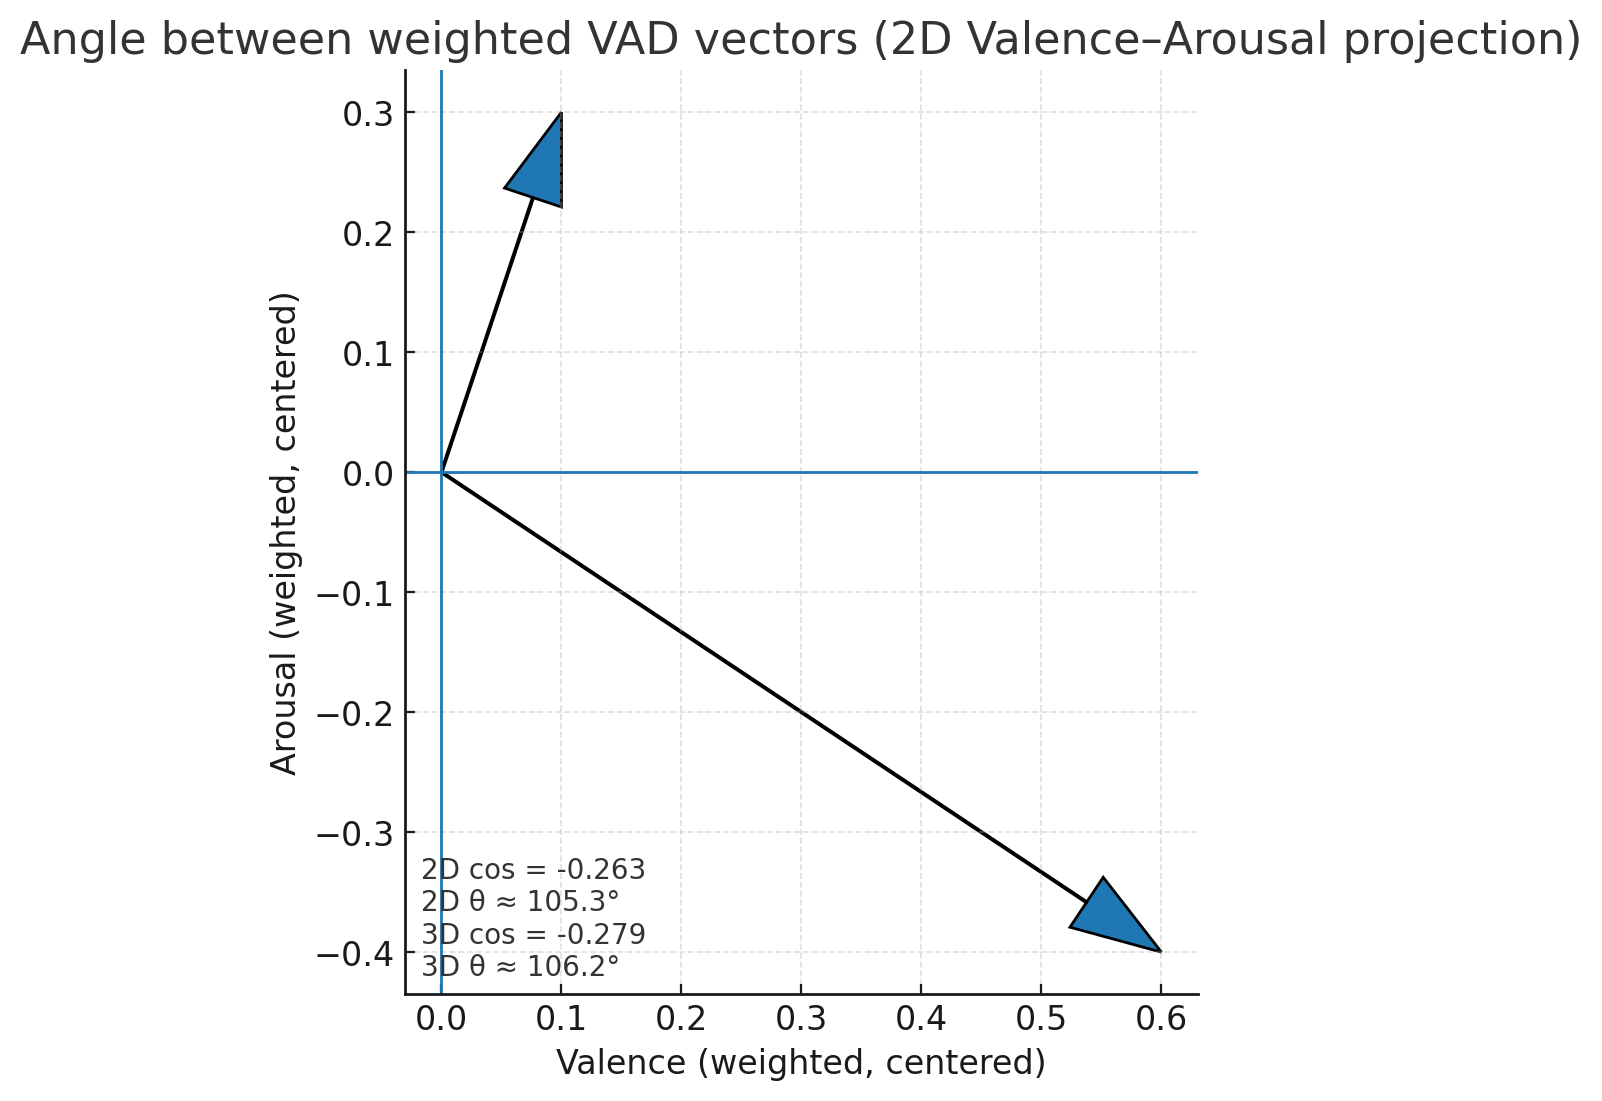

I plotted a simple 2D projection (Valence–Arousal plane) and also computed the full **3D** cosine (Valence–Arousal–Dominance). The on-plot angle is for the 2D picture; the printed numbers include both 2D and 3D so you can compare.

* The arrows start at the origin and end at the (weighted, centered) VAD points.
* The text box shows `cos` and the angle `θ` in degrees.
* Negative cosine (angle > 90°) means the two vibes pull in **different directions**.

If you want me to re-run with your actual user and movie VADs, paste them and I’ll drop them into the same visual.


Great Q! Here’s the intuition behind `distance_score` and why we blend it with cosine.

## What `distance_score` is

* First compute the **weighted Euclidean distance** between the two (centered, weighted) VAD vectors:

  $$
  d=\lVert \tilde u-\tilde m\rVert_2
  \quad\text{where}\quad \tilde u=w\odot u',\ \tilde m=w\odot m'
  $$
* Find the **maximum possible** such distance in this space:

  $$
  d_{\max}=2\,\sqrt{\sum_i w_i^2}
  $$

  (Opposite corners in \[-1,1]^3, with weights.)
* Convert distance to a **similarity** in $[0,1]$:

  $$
  \text{distance\_score}=1-\frac{d}{d_{\max}}
  $$

  * 1.0 = identical vibe
  * 0.0 = as far apart as possible

## Why we combine it with cosine

* **Cosine** measures **direction** (the “type” of vibe). It ignores length. Two vectors can have a very high cosine (same direction) even if one is **much more intense** than the other.
* **Distance** measures **both direction and intensity mismatch**. If energy/strength differs a lot (e.g., calm vs. very high arousal), distance penalizes that gap.

So we blend them:

$$
\text{score}=\alpha\cdot \text{cosine}+(1-\alpha)\cdot \text{distance\_score}
$$

* $\alpha$ is a **knob**:

  * Higher $\alpha$ → prioritize **direction** (cosine).
  * Lower $\alpha$ → prioritize **overall closeness** (distance).

### Tiny examples

* **Same direction, different intensity**: cosine ≈ 1.0, distance\_score < 1.0 → blend lowers the score a bit to reflect intensity mismatch.
* **Similar intensity but wrong direction**: cosine < 0 (opposite), distance\_score also low → blend penalizes a lot.
* **Both match**: cosine ≈ 1.0 and distance\_score ≈ 1.0 → score near 1.0.

## Range note (optional tweak)

* Cosine is in **\[-1, 1]**, distance\_score in **\[0, 1]**, so the blended score lies in **\[-α, 1]**.
  If you prefer a pure **\[0,1]** final score, rescale cosine first:

  $$
  \text{cos1}=\frac{\text{cosine}+1}{2}\ \in[0,1],\quad
  \text{score}=\alpha\cdot \text{cos1}+(1-\alpha)\cdot \text{distance\_score}.
  $$

## When this helps most

* Users describe a vibe (“moody but gentle”) and you want **direction + intensity** to line up.
* Prevents ranking a **hyper-intense** match above a **moderate, closer** match when the user asked for something chill.

Default that works well in practice:

* Weights $w=(1.0,1.0,0.7)$ (dominance slightly down-weighted)
* Blend $\alpha=0.6$ (favor direction, respect intensity)


Great question. In that formula

$$
d_{\max}=2\,\sqrt{\sum_i w_i^2}
$$

the $w_i$ are the **per-axis weights** you chose for Valence, Arousal, and Dominance. For example, if you set $w=(1.0,\;1.0,\;0.7)$, that means:

* $w_1=1.0$ for **Valence**
* $w_2=1.0$ for **Arousal**
* $w_3=0.7$ for **Dominance** (down-weighted)

### Why that’s the max distance

1. After preprocessing, both vectors live in $[-1,1]^3$.
2. You weight each axis: $\tilde{u} = w \odot u'$, $\tilde{m} = w \odot m'$.
3. The (weighted) Euclidean distance is:

   $$
   d = \|\tilde{u}-\tilde{m}\|_2
     = \sqrt{\sum_i \big(w_i (u'_i - m'_i)\big)^2}.
   $$
4. The **largest** possible difference along any axis in $[-1,1]$ is $2$ (from $-1$ to $+1$). If the two vectors sit at **opposite corners** of the cube, each axis contributes $|u'_i - m'_i| = 2$. Plugging that in:

   $$
   d_{\max} = \sqrt{\sum_i (w_i \cdot 2)^2}
            = \sqrt{\sum_i 4\,w_i^2}
            = 2\,\sqrt{\sum_i w_i^2}.
   $$

So $w$ directly scales each axis’s contribution to the maximum possible distance.

### Numeric example

With $w=(1.0,\;1.0,\;0.7)$:

$$
\sum_i w_i^2 = 1^2 + 1^2 + 0.7^2 = 2.49,\quad
\sqrt{2.49} \approx 1.578,\quad
d_{\max} = 2 \times 1.578 \approx 3.157.
$$

We then map any actual distance $d$ to a similarity:

$$
\text{distance\_score} = 1 - \frac{d}{d_{\max}} \in [0,1].
$$

### Generalization (if your ranges change)

If an axis doesn’t use $[-1,1]$, replace “2” with that axis’s **range length** $L_i$:

$$
d_{\max} = \sqrt{\sum_i (w_i \, L_i)^2}.
$$

In our case $L_i = 2$ for all three because of the $[0,1]\to[-1,1]$ recentering step.


Yeah—I agree. When a prompt packs lots of rules + long few-shots, small classifiers start “hallucinating” shortcuts (e.g., mapping “sinister” → TEEN because of a stray prior example). Let’s simplify and **decouple**:

# The fix in practice

## 1) Run attributes in separate classifiers

One call for **view\_type**, another for **genre**, another for **audience**, another for **VAD**. Don’t mix their rules or few-shots.

## 2) Make the view\_type prompt tiny and *format-only*

Tell it to ignore mood/genre/audience completely. Keep few-shots to 2–3 max.

```python
VIEW_TYPES = ["Movie","TV Series","Miniseries"]

VIEWTYPE_SYSTEM = f"""
You extract the desired viewing format. Output JSON ONLY:
{{"view_types": ["Movie","TV Series","Miniseries"]}} or {{"view_types": []}}.

Rules:
- Consider ONLY format words. Ignore mood, genre, age/audience, VAD.
- Normalize synonyms:
  movie/film/feature → "Movie"
  tv show/tv series/show/series/docuseries → "TV Series"
  miniseries/limited series/limited → "Miniseries"
- If multiple formats are explicitly mentioned, list them in order of mention.
- If none mentioned or ambiguous, return [].
- No extra keys or commentary.
""".strip()

view_type_few_shots = [
    # minimal, format-focused examples
    {"role": "user", "content": "I want a TV show to binge this weekend."},
    {"role": "assistant", "content": json.dumps({"view_types": ["TV Series"]})},

    {"role": "user", "content": "Any good limited series about true crime?"},
    {"role": "assistant", "content": json.dumps({"view_types": ["Miniseries"]})},

    {"role": "user", "content": "Looking for a movie tonight."},
    {"role": "assistant", "content": json.dumps({"view_types": ["Movie"]})},
]

def build_viewtype_messages(request_text: str):
    return (
        [{"role": "system", "content": VIEWTYPE_SYSTEM}]
        + view_type_few_shots
        + [{"role": "user", "content": request_text}]
    )
```

**Why this helps:** there’s nothing in the system or few-shots about “Teen”, “genre”, etc., so the model has fewer paths to drift.

**Settings:** set `temperature=0` (or ≤0.2) and `top_p=1`. This makes the classifier more literal.

---

## 3) Genre classifier is separate (use your dataset labels)

Keep your dataset-faithful `ALLOWED_GENRES` and the validator you added. Make the **genre** system message short as well, and keep few-shots to 3–5 tops. (We already drafted a slim version—happy to trim it further if you want.)

---

## 4) Add a cheap pre-pass (optional but powerful)

Before you even call the LLM for **view\_type**, do a tiny regex scan:

```python
import re

def heuristic_view_types(text: str) -> list[str]:
    t = text.lower()
    out = []
    if re.search(r"\b(mini[-\s]?series|limited series|limited)\b", t):
        out.append("Miniseries")
    if re.search(r"\b(tv\s?(show|series)|show|series|docuseries)\b", t):
        out.append("TV Series")
    if re.search(r"\b(movie|film|feature)\b", t):
        out.append("Movie")
    # preserve order of mention (simple heuristic)
    order = []
    for m in re.finditer(r"(mini[-\s]?series|limited series|limited|tv\s?(show|series)|show|series|docuseries|movie|film|feature)", t):
        token = m.group(0)
        if token.startswith(("mini","limited")) and "Miniseries" not in order and "Miniseries" in out:
            order.append("Miniseries")
        elif any(k in token for k in ["tv show","tv series","series","show","docuseries"]):
            if "TV Series" in out and "TV Series" not in order:
                order.append("TV Series")
        elif any(k in token for k in ["movie","film","feature"]):
            if "Movie" in out and "Movie" not in order:
                order.append("Movie")
    return order
```

* If `order` is nonempty, you can **skip the LLM** and return it directly.
* If empty, fall back to the tiny LLM classifier above.

This removes almost all drift for view\_type and speeds things up.

---

## 5) Quick test on your sentence

Input: “I’m in the mood for sinister, **crime movie**, that has a lot of car chases and shoot outs.”

* Heuristic finds “movie” → `["Movie"]`
* Even if you hit the LLM, the tiny prompt focuses only on format words, so it returns `{"view_types": ["Movie"]}`—no “TEEN”.

---

Want me to trim your **genre** system message and few-shots the same way (short + targeted), and wire both into your `build_messages()` pattern?
